#Preamble

We may need the skopt and keras-tuner modules.  If so, we can install using pip:

In [ ]:
!pip install scikit-optimize
!pip install keras-tuner

     |████████████████████████████████| 100 kB 3.4 MB/s 
     |████████████████████████████████| 98 kB 3.2 MB/s 


We'll also need to load the standard libraries.  Specific libraries will vary based on the optimization strategy, but we will need tf and keras at minimum.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
import skopt
import skopt.space as sp
import matplotlib.pyplot as plt
import numpy as np

# Problem 1 -- Generate the model

Develop a function 

    build_network(nslayers, n_neurons_per_layer, activation_fn)

The function should return a compiled model with the following structure:
* An Input node accepting an image of dimensions $28\times28$
* A Flatten node
* $n$ hidden layer nodes, each containing `n_neurons_per_layer` neurons and using the activation function `activation_fn`.
* An output layer (Dense layer) of 10 neurons that uses the softmax activation function.


The model should be compiled as such:
* Optimizer: sgd
* metrics: `["accuracy"]`
* loss: `sparse_categorical_crossentropy` (since the target variable is represented as a single value, as opposed to being one-hot encoded)



In [ ]:
def build_network(n_layers, n_neurons_per_layer, activation_fn):
  model = Sequential()
  model.add(Input(shape=(28,28)))
  model.add(Flatten())
  for _ in tf.range(n_layers):
    model.add(Dense(n_neurons_per_layer, activation=activation_fn))
  model.add(Dense(10, "softmax"))
  model.compile(optimizer="sgd", 
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"]
                )
  return model

## Problem 2 -- Load the keras MNIST dataset. 

Call `keras.datasets.mnist.load_data("mnist.npz")`, which returns 
`(X_train, y_train), (X_test, y_test)`.  Split the training dataset into a training and validation set.

We will load the dataset using the keras library.  As we often do, we can use 80% of the set for training, and the remaining 20% for testing.

In [ ]:
#we can cache the dataset by providing a filename in the argument
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data("mnist.npz")

valbound = int(X_train_full.shape[0] * 0.8)

# values are from 0-255; we need to scale to ~0-1 range by dividing by 255
X_train, X_val = X_train_full[:valbound]/255, X_train_full[valbound:]/255
y_train, y_val = y_train_full[:valbound], y_train_full[valbound:]

#Problem 3 -- Train the model.

Call `build_network` with parameters of your choice (4-8 layers, 50-150 neurons per layer, and ReLU activation (`relu`) is a reasonable starting point.)  Train the model against the training dataset.  To reduce training time, an early stopping callback is advised.  Evaluate the model using the validation dataset.  What is the prediction accuracy of the neural net?



Let's say we build with 5 layers, 200 neurons per layer.  We'll set aside a further 20% validation split to monitor validation accuracy.

In [ ]:
model = build_network(5, 200, "relu")
early_stopping_cb = EarlyStopping(monitor='val_loss', 
                                  min_delta = 0.001, 
                                  patience=3)
hist = model.fit(X_train, y_train, 
                 epochs=20, 
                 callbacks=[early_stopping_cb],
                 validation_split=0.2)

Epoch 1/20
1200/1200 [==============================] - 6s 5ms/step - loss: 0.8810 - accuracy: 0.7465 - val_loss: 0.3540 - val_accuracy: 0.8953
Epoch 2/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2973 - accuracy: 0.9119 - val_loss: 0.2833 - val_accuracy: 0.9127
Epoch 3/20
1200/1200 [==============================] - 5s 5ms/step - loss: 0.2244 - accuracy: 0.9337 - val_loss: 0.2184 - val_accuracy: 0.9342
Epoch 4/20
1200/1200 [==============================] - 5s 5ms/step - loss: 0.1814 - accuracy: 0.9468 - val_loss: 0.2072 - val_accuracy: 0.9348
Epoch 5/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1500 - accuracy: 0.9558 - val_loss: 0.1932 - val_accuracy: 0.9384
Epoch 6/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1274 - accuracy: 0.9627 - val_loss: 0.1617 - val_accuracy: 0.9501
Epoch 7/20
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1089 - accuracy: 0.9679 - val_loss: 0.1485 - val_accuracy:

The validation accuracy indicates an unbiased predictive accuracy of about 96.5%. We can confirm by evaluating against the evaluation dataset:

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"validation accuracy: {accuracy:0.4f}")

375/375 [==============================] - 1s 2ms/step - loss: 0.1108 - accuracy: 0.9720
validation accuracy: 0.9720


Accuracy against the test dataset is 0.972.

While not part of the assignment, we might be insterested in the inputs our network mispredicted.  We can plot some like so:

In [ ]:
y_pred = tf.argmax(model.predict(X_val), axis=1)

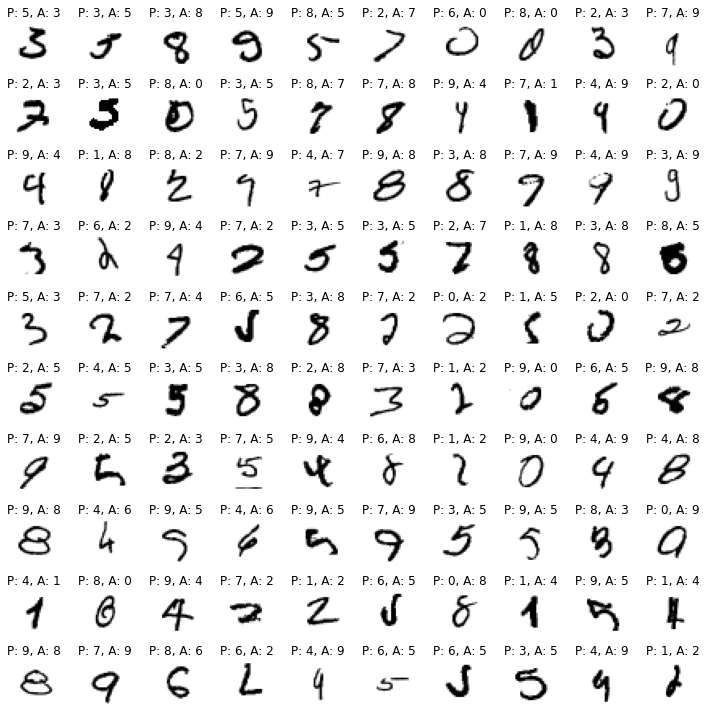

In [ ]:
samp = tf.random.shuffle(tf.where(y_pred != y_val), seed=0)[:100]
fig, axs = plt.subplots(10,10, figsize=(10,10))
axs = np.array(axs).ravel()
for ix, ax in zip(samp, axs):
  ix = tuple(ix)
  ax.imshow(X_val[ix], cmap="gray_r")
  ax.set_title(f"P: {y_pred[ix]}, A: {y_val[ix]}")
  ax.set_axis_off()
fig.tight_layout()

#Problem 4 -- Optimize the model.

Use one of the hyperparameter optimization frameworks discussed in class, such as scikit-optimize, to find an optimal values of the number of layers, activation function, and neurons per layer for this neural network.  Use a budget of about 20 runs.  Use the below tables as rough guideline for parameter space.

|Parameter|Space ($\Lambda$)|
|---------|----|
|Activation function|`relu`, `sigmoid`|
|Number of layers|~2-20 (integer, uniform)|
|Number of neurons per layers|10-300 (integer, log distributed)|

What combination of parameters ($\lambda$) produces the highest accuracy, and what is that accuracy?





Solutions will vary.  Some examples are shown below.

#Hyperopt

For hyperopt, we define an objective function that returns the negative accuracy.  We can also return the loss function directly.  Refer to the [Hyperopt documentation](http://hyperopt.github.io/hyperopt/) and [implementing article](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf) for details on the syntax.  Expect 2-3 minutes per trial, or 40 minutes to an hour to run 20 trials.

In [ ]:
from hyperopt import (fmin, hp, tpe, Trials, STATUS_OK, STATUS_FAIL)
import time
import numpy as np

def hyperopt_objective(args):
  act_fn, n_layer, n_neurons = [args[k] for k in ['activation', 'n_layers', 'neurons_per_layer']]
  n_layer, n_neurons = [int(k) for k in [n_layer, n_neurons]]
  model = build_network(n_layer, n_neurons, act_fn)
  model.fit(X_train, 
            y_train, 
            epochs=20, 
            callbacks=[early_stopping_cb],
            validation_split=0.2,
            verbose=0)
  _, accuracy = model.evaluate(X_val, y_val, verbose=0)
  return {'loss': -accuracy,
            'time': time.time(),
            'status': STATUS_OK,
            'model': model}

In [ ]:
trials = Trials()
fmin(
        hyperopt_objective,
        {
          'activation': hp.choice('activation', ["relu", "sigmoid"]),
          'n_layers': hp.quniform("n_layers", 2, 9, 1),
          'neurons_per_layer': hp.quniform("neurons_per_layer", 10, 1000, 1)
        },
        algo=tpe.suggest,
        max_evals=20,
        verbose=0,
        trials=trials,
        show_progressbar=True
)
print(trials)
print(trials.best_trial)

100%|██████████| 20/20 [1:29:37<00:00, 268.86s/it, best loss: -0.9754999876022339]
{'state': 2, 'tid': 10, 'spec': None, 'result': {'loss': -0.9754999876022339, 'time': 1636174039.8535988, 'status': 'ok', 'model': <keras.engine.sequential.Sequential object at 0x7f974579b490>}, 'misc': {'tid': 10, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'activation': [10], 'n_layers': [10], 'neurons_per_layer': [10]}, 'vals': {'activation': [0], 'n_layers': [5.0], 'neurons_per_layer': [841.0]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 11, 6, 4, 34, 54, 161000), 'refresh_time': datetime.datetime(2021, 11, 6, 4, 47, 19, 853000)}


In [ ]:
best_model = trials.best_trial['result']['model']
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"validation accuracy: {accuracy:0.4f}")

375/375 [==============================] - 4s 10ms/step - loss: 0.0968 - accuracy: 0.9755
validation accuracy: 0.9755


## Hyperband



A solution using the Hyperband tuner included in KerasTuner is below.  (A hyperband solution that performs 5 iterations using a GPU is provided as a separate notebook.)

In [ ]:
import keras_tuner as ktuner
from keras_tuner import HyperParameters

hp = HyperParameters()
def hyperband_candidate_model(hp: HyperParameters):
  afn = hp.Choice("activation_fn", ["relu", "sigmoid"])
  nlayers = hp.Int("layers", 2, 21)
  neuronsperlayer = hp.Int("neurons_per_layer", 10, 1000, sampling="log")
  return build_network(nlayers, neuronsperlayer, afn)

In [ ]:
tuner = ktuner.Hyperband(hyperband_candidate_model,
                hyperband_iterations=1,
                project_name='mnist',
                objective='val_accuracy',
                max_epochs=27)

In [ ]:
search = tuner.search(X_train, y_train,
        epochs=20,
        callbacks=[EarlyStopping(min_delta = 0.001, patience=3)],
        validation_split=0.2)  

Trial 71 Complete [00h 01m 10s]
val_accuracy: 0.11520833522081375

Best val_accuracy So Far: 0.9659374952316284
Total elapsed time: 01h 30m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'activation_fn': 'relu',
 'layers': 4,
 'neurons_per_layer': 135,
 'tuner/bracket': 2,
 'tuner/epochs': 27,
 'tuner/initial_epoch': 9,
 'tuner/round': 2,
 'tuner/trial_id': 'a595818f185a06c4fcf373b1da3f8614'}

In [ ]:
loss, accuracy = tuner.get_best_models()[0].evaluate(X_val, y_val)
print(f"validation accuracy: {accuracy:0.4f}")

375/375 [==============================] - 1s 2ms/step - loss: 0.1065 - accuracy: 0.9705
validation accuracy: 0.9705
